In [44]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import pandas as pd
import time
from scipy.signal import savgol_filter
import scipy.signal as signal
import subprocess as sp
from tqdm import tqdm_notebook as tqdm

In [2]:
def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True):
    # WINDOW_SIZE=500
    max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = min(len(frames[master]), len(timestamps[master]))
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search==min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
                
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)

def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(270,480)):
    lefts = []
    rights = []
    row = LUT.iloc[index,:]
    t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts.append(left)
        rights.append(right)
            
    return(lefts, rights)

# Read 1000 frames into memory for benchmarking

In [3]:
datadir = r'/media/jim/FASTER/realsense/190326/JB040_large_750us_1050mALEDs_193926_143919'
camnames = ['left_ant', 'left_post', 'right_ant', 'right_post']

camfiles = {i:os.path.join(datadir, i+'.h5') for i in camnames}
for key, file in camfiles.items():
    assert(os.path.isfile(file))
print(camfiles)

{'left_ant': '/media/jim/FASTER/realsense/190326/JB040_large_750us_1050mALEDs_193926_143919/left_ant.h5', 'left_post': '/media/jim/FASTER/realsense/190326/JB040_large_750us_1050mALEDs_193926_143919/left_post.h5', 'right_ant': '/media/jim/FASTER/realsense/190326/JB040_large_750us_1050mALEDs_193926_143919/right_ant.h5', 'right_post': '/media/jim/FASTER/realsense/190326/JB040_large_750us_1050mALEDs_193926_143919/right_post.h5'}


In [4]:
N = 250
LUT = align_cameras_on_timestamps(camfiles)

In [6]:
indices = range(1000,1250)
lefts, _ = get_frames_by_index(camfiles, LUT, indices[0], blank_frame=True)

width = lefts[0].shape[1]
height = lefts[0].shape[0]

In [7]:
indices = range(1000,1250)

stack = np.zeros((height,width*2,1000),dtype=np.uint8)
cnt = 0
for cam in range(4):
    for i in indices:
        lefts, rights = get_frames_by_index(camfiles, LUT, i, blank_frame=True)
        left, right = lefts[cam], rights[cam]
        out = np.hstack((left,right))
        stack[...,cnt] = out
        cnt+=1

In [8]:
framesize = stack.shape[1],stack.shape[0]

In [10]:
fps = 30
outdir = r'/media/jim/FASTER/realsense/benchmarking'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
filename = 'benchmark_stack.avi'
writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)
for i in range(1000):
    frame = cv2.cvtColor(stack[...,i], cv2.COLOR_GRAY2RGB)
    writer.write(frame)
writer.release()

# write append methods
* HDF5
* openCV
* ffmpeg

In [11]:
outdir = r'/media/jim/FASTER/realsense/benchmarking'

In [12]:
def initialize_hdf5(fname='benchmark.h5', outdir=outdir):
    f = h5py.File(os.path.join(outdir, fname), 'w')
    datatype = h5py.special_dtype(vlen=np.dtype('uint8'))
    dset = f.create_dataset('left', (0,), maxshape=(None,),dtype=datatype)
    dset = f.create_dataset('right', (0,), maxshape=(None,),dtype=datatype)
    return(f)

def append_to_hdf5(f, left, right, axis=0):
    ret1, left_jpg = cv2.imencode('.jpg', left, (cv2.IMWRITE_JPEG_QUALITY,80))
    ret2, right_jpg = cv2.imencode('.jpg', right, (cv2.IMWRITE_JPEG_QUALITY,80))
    
    f['left'].resize(f['left'].shape[axis]+1, axis=axis)
    f['left'][-1]=left_jpg.squeeze()
    f['right'].resize(f['right'].shape[axis]+1, axis=axis)
    f['right'][-1]=right_jpg.squeeze()

In [32]:
def initialize_opencv(framesize, codec, fname='benchmark_opencv.avi', outdir=outdir):
    fourcc = cv2.VideoWriter_fourcc(*codec)
    writer = cv2.VideoWriter(os.path.join(outdir, fname),fourcc, 30, framesize)
    return(writer)
def append_to_opencv(writer, left, right):
    out = cv2.cvtColor(np.hstack((left, right)), cv2.COLOR_GRAY2RGB)
    writer.write(out)

In [85]:
def initialize_ffmpeg(framesize, fname='benchmark_ffmpeg.avi', outdir=outdir):
    size_string = '%dx%d' %framesize
    outname = os.path.join(outdir, fname)
    command = [ 'ffmpeg',
        '-threads', '1',
        '-y', # (optional) overwrite output file if it exists
        '-f', 'rawvideo',
        '-vcodec','rawvideo',
        '-s', size_string, # size of one frame
        '-pix_fmt', 'rgb24',
        '-r', '30', # frames per second
        '-i', '-', # The imput comes from a pipe
        '-an', # Tells FFMPEG not to expect any audio
        '-vcodec', 'libx264',
        '-crf', '23', 
        outname]
    pipe = sp.Popen( command, stdin=sp.PIPE, stderr=sp.STDOUT)
    return(pipe)
# from here 
# https://zulko.github.io/blog/2013/09/27/read-and-write-video-frames-in-python-using-ffmpeg/
def append_to_ffmpeg(pipe, left,right):
    out = cv2.cvtColor(np.hstack((left,right)), cv2.COLOR_GRAY2RGB)
    try:
        pipe.stdin.write(out.tobytes())
    except BaseException as err:
        _, ffmpeg_error = pipe.communicate()
        error = (str(err) + ("\n\nerror: FFMPEG encountered "
                             "the following error while writing file:"
                             "\n\n %s" % (str(ffmpeg_error))))
#     try:
#         outs, errs = pipe.communicate(input=out.tobytes(), timeout=5)
#     except sp.TimeoutExpired:
#         pipe.kill()
#         outs, errs = pipe.communicate()
#         print(outs,errs)
#     except BaseException:
#         pipe.kill()
#         outs, errs = pipe.communicate()
#         print(outs,errs)
#         fuck
        

# Make sure valid files are written

### HDF5

In [20]:
hdf5_file = initialize_hdf5()
splitcol = stack.shape[1]//2
ts = np.zeros((1000,),dtype=np.float64)
try:
    for i in range(1000):
        frame = stack[...,i]
        left = frame[:,:splitcol]
        right = frame[:,splitcol:]
        t = time.perf_counter()
        append_to_hdf5(hdf5_file, left,right)
        ts[i] = time.perf_counter()-t
except Exception as e:
    # print(e)
    fuck
finally:
    hdf5_file.close()

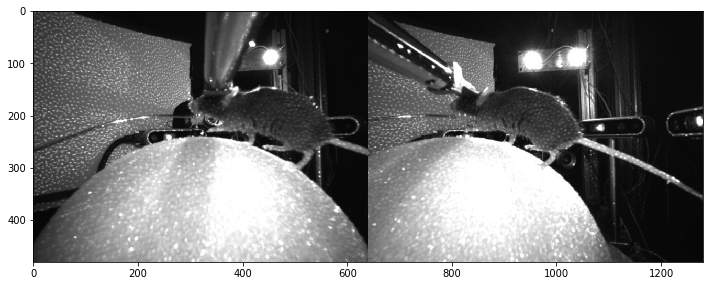

In [22]:
with h5py.File(os.path.join(outdir, 'benchmark.h5'), 'r') as f:
    left = cv2.imdecode(f['left'][0], 0)
    right = cv2.imdecode(f['right'][0],0)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(np.hstack((left,right)), 'gray')
plt.show()

In [25]:
def plot_ts(ts, title=None, ax=None,indices=None):
    if indices is None:
        indices = range(0,len(ts))
    plt.style.use('ggplot')
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(indices,ts[indices]*1000)
    ax.set_xlabel('indices')
    ax.set_ylabel('Marginal frame writing time (ms)')
    ax.set_title(title)

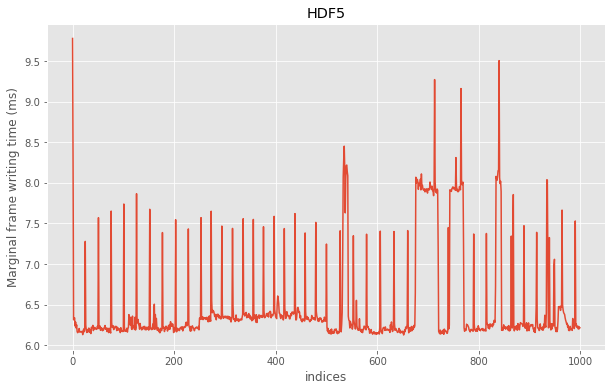

In [27]:
plot_ts(ts, title='HDF5')

### opencv

In [34]:
opencv_writer = initialize_opencv(framesize=(stack.shape[1],stack.shape[0]),
                                 codec='MJPG')
# splitcol = stack.shape[1]//2
ts = np.zeros((1000,),dtype=np.float64)
try:
    for i in range(1000):
        frame = stack[...,i]
        left = frame[:,:splitcol]
        right = frame[:,splitcol:]
        t = time.perf_counter()
        append_to_opencv(opencv_writer, left,right)
        ts[i] = time.perf_counter()-t
except Exception as e:
    # print(e)
    fuck
finally:
    opencv_writer.release()

AttributeError: 'cv2.VideoWriter' object has no attribute 'close'

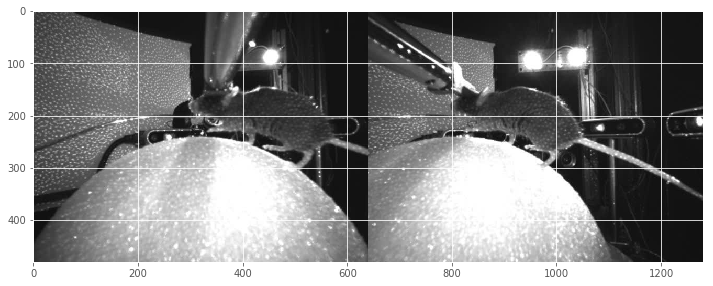

In [37]:
cap = cv2.VideoCapture(os.path.join(outdir, 'benchmark_opencv.avi'))
ret, frame = cap.read()
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(frame, 'gray')
plt.show()

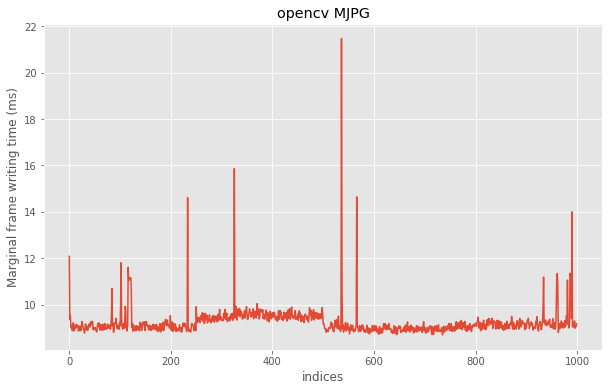

In [38]:
plot_ts(ts, title='opencv MJPG')

### FFMPEG

In [48]:
pipe = initialize_ffmpeg(framesize=(stack.shape[1],stack.shape[0]))
# splitcol = stack.shape[1]//2
ts = np.zeros((1000,),dtype=np.float64)
try:
    for i in range(1000):
        frame = stack[...,i]
        left = frame[:,:splitcol]
        right = frame[:,splitcol:]
        t = time.perf_counter()
        append_to_ffmpeg(pipe, left,right)
        # append_to_opencv(opencv_writer, left,right)
        ts[i] = time.perf_counter()-t
except Exception as e:
    # print(e)
    fuck
finally:
    pipe.stdin.close()
    if pipe.stderr is not None:
        pipe.stderr.close()
    pipe.wait()
    del(pipe)

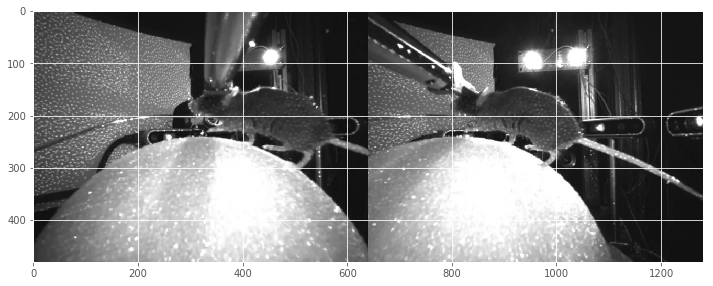

In [49]:
cap = cv2.VideoCapture(os.path.join(outdir, 'benchmark_ffmpeg.avi'))
ret, frame = cap.read()
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(frame, 'gray')
plt.show()

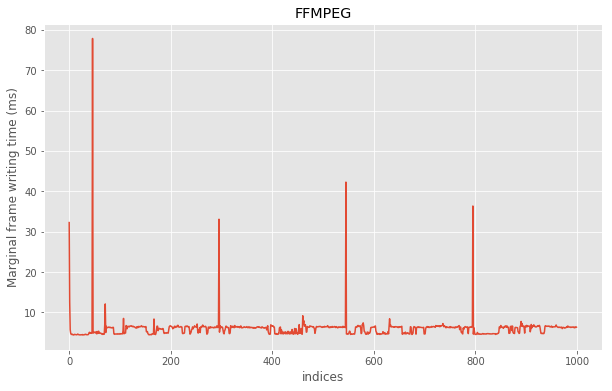

In [50]:
plot_ts(ts, title='FFMPEG')

# Write benchmarking script

In [55]:
million = int(1000000)
num_loops = million//1000

In [57]:
hdf5_file = initialize_hdf5()
splitcol = stack.shape[1]//2
hdf5_ts = np.zeros((million,),dtype=np.float64)
cnt=0
try:
    for _ in tqdm(range(num_loops)):
        for i in range(1000):
            frame = stack[...,i]
            left = frame[:,:splitcol]
            right = frame[:,splitcol:]
            t = time.perf_counter()
            append_to_hdf5(hdf5_file, left,right)
            hdf5_ts[cnt] = time.perf_counter()-t
            cnt+=1
except Exception as e:
    # print(e)
    fuck
finally:
    hdf5_file.close()
    
    
opencv_writer = initialize_opencv(framesize=(stack.shape[1],stack.shape[0]),
                                 codec='DIVX')
# splitcol = stack.shape[1]//2
opencv_ts = np.zeros((million,),dtype=np.float64)
cnt=0
try:
    for _ in tqdm(range(num_loops)):
        for i in range(1000):
            frame = stack[...,i]
            left = frame[:,:splitcol]
            right = frame[:,splitcol:]
            t = time.perf_counter()
            append_to_opencv(opencv_writer, left,right)
            opencv_ts[cnt] = time.perf_counter()-t
            cnt+=1
except Exception as e:
    # print(e)
    fuck
finally:
    opencv_writer.release()
   

KeyboardInterrupt: 

In [77]:
import traceback

In [86]:
pipe = initialize_ffmpeg(framesize=(stack.shape[1],stack.shape[0]))
# splitcol = stack.shape[1]//2
ffmpeg_ts = np.zeros((million,),dtype=np.float64)
cnt=0
try:
    for _ in tqdm(range(num_loops)):
        for i in range(1000):
            frame = stack[...,i]
            left = frame[:,:splitcol]
            right = frame[:,splitcol:]
            t = time.perf_counter()
            append_to_ffmpeg(pipe, left,right)
            # append_to_opencv(opencv_writer, left,right)
            ffmpeg_ts[cnt] = time.perf_counter()-t
            cnt+=1
except Exception as e:
    # print(e)
    traceback.print_exc()
finally:
    pipe.stdin.close()
    if pipe.stderr is not None:
        pipe.stderr.close()
    pipe.wait()
    del(pipe)

In [89]:
bin_edges = np.arange(0, len(t), 1000)

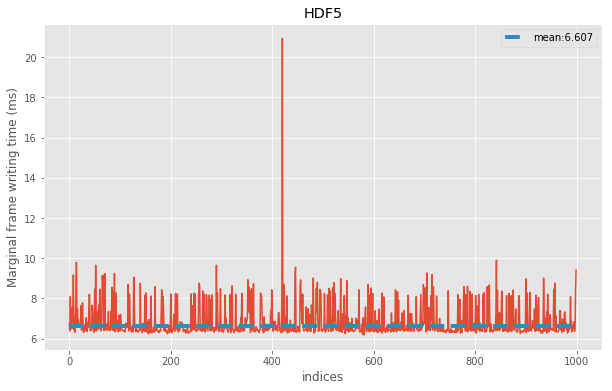

In [106]:
t = hdf5_ts.copy()
binned = np.array([np.mean(t[i:i+1]) for i in bin_edges])

plot_ts(binned, 'HDF5')
ax = plt.gca()
mean_t = t.mean()*1000
xs = [0, len(binned)]
ax.plot(xs, [mean_t, mean_t], '--', lw=4, label='mean:%.3f'%mean_t)
ax.legend()

plt.show()

In [109]:
binned.mean()*1000

8.399402663751971

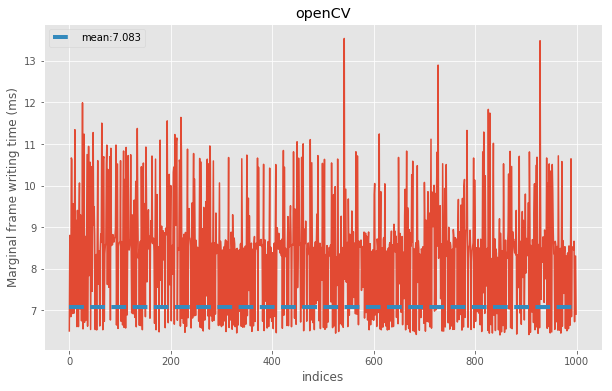

In [107]:
t = opencv_ts.copy()
binned = np.array([np.mean(t[i:i+1]) for i in bin_edges])

plot_ts(binned, 'openCV')
ax = plt.gca()
mean_t = t.mean()*1000
xs = [0, len(binned)]
ax.plot(xs, [mean_t, mean_t], '--', lw=4, label='mean:%.3f'%mean_t)
ax.legend()

plt.show()

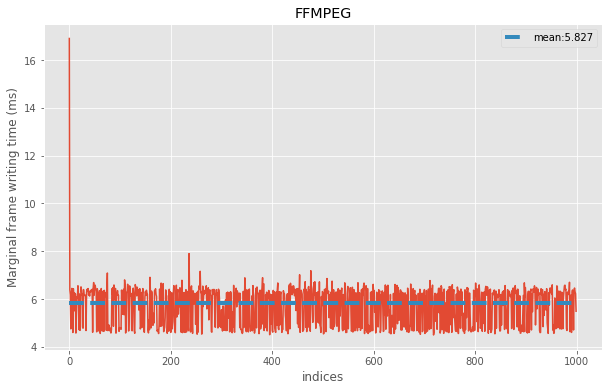

In [110]:
t = ffmpeg_ts.copy()
binned = np.array([np.mean(t[i:i+1]) for i in bin_edges])

plot_ts(binned, 'FFMPEG')
ax = plt.gca()
mean_t = t.mean()*1000
xs = [0, len(binned)]
ax.plot(xs, [mean_t, mean_t], '--', lw=4, label='mean:%.3f'%mean_t)
ax.legend()

plt.show()